<a href="https://colab.research.google.com/github/PsyCapsLock/PubBiasDetect/blob/main/Scripts/Scibert_2023_07_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Transformers installation
!pip install transformers datasets evaluate  
!pip install transformers[torch]
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
from datasets import load_dataset


## own data
url1 = 'https://github.com/PsyCapsLock/PubBiasDetect/blob/main/Data/Datasets/train_full_valid_two_classes_2023-07-13.csv?raw=true'
url2 = 'https://github.com/PsyCapsLock/PubBiasDetect/blob/main/Data/Datasets/test_full_valid_two_classes_2023-07-13.csv?raw=true'
url3 = 'https://github.com/PsyCapsLock/PubBiasDetect/blob/main/Data/Datasets/dev_full_valid_two_classes_2023-07-13.csv?raw=true'


dataset = load_dataset('csv', data_files={'train': url1,
                                          'test': url2,
                                          'dev': url3})

train_dataset = dataset["train"]
test_dataset = dataset["test"]
dev_dataset = dataset["dev"]



Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7200163334535af9/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
## labels
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

from datasets import ClassLabel, Value

## train
new_features_train = dataset["train"].features.copy()
new_features_train["label"] = Value("int64")
new_features_train["label"] = ClassLabel(names=["negative", "positive"])
dataset["train"] = dataset["train"].cast(new_features_train)

## dev
new_features_dev = dataset["dev"].features.copy()
new_features_dev["label"] = Value("int64")
new_features_dev["label"] = ClassLabel(names=["negative", "positive"])
dataset["dev"] = dataset["dev"].cast(new_features_test)

## test
new_features_test = dataset["test"].features.copy()
new_features_test["label"] = Value("int64")
new_features_test["label"] = ClassLabel(names=["negative", "positive"])
dataset["test"] = dataset["test"].cast(new_features_test)


Casting the dataset:   0%|          | 0/1469 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/166 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/184 [00:00<?, ? examples/s]

In [ ]:
def remove_first_20_percent(example):
    length_to_remove = int(len(example['text']) * 0.2)
    example['text'] = example['text'][length_to_remove:]
    return example



# Apply the function to the "text" column
#dataset = dataset.map(remove_first_20_percent)


In [ ]:
## load tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

## preprocess
def preprocess_function(examples):
    return tokenizer(examples["text"],
                     truncation=True,
                     max_length=512,
                     padding='max_length'
                     )

## map
tokenized_full = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/1469 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

In [ ]:

## data collator
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## accuraracy
import evaluate
accuracy = evaluate.load("accuracy")


## metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(predictions, labels, average="weighted")
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(
    "allenai/scibert_scivocab_uncased", num_labels=2, id2label=id2label, label2id=label2id
)


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_total_limit = 2,
    eval_steps = 100,
    logging_steps = 20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    load_best_model_at_end=True,
    push_to_hub=True,
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_full["train"],
    eval_dataset=tokenized_full["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/content/my_awesome_model is already a clone of https://huggingface.co/ClinicalMetaScience/my_awesome_model. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

# Train the model and get training history
training_history = trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.368700,0.329513,0.879518,0.879518,0.879518,0.879518
2,0.283700,0.244893,0.921687,0.921650,0.921680,0.921687
3,0.195200,0.235180,0.927711,0.927711,0.927711,0.927711


In [ ]:
predict_train=trainer.predict(tokenized_full["test"])



In [ ]:
print(predict_train.predictions)

print(predict_train.label_ids)
print(predict_train.metrics)





{'test_loss': 0.26736998558044434, 'test_accuracy': 0.9239130434782609, 'test_f1': 0.9239130434782609, 'test_precision': 0.9239130434782609, 'test_recall': 0.9239130434782609, 'test_runtime': 5.8237, 'test_samples_per_second': 31.595, 'test_steps_per_second': 2.061}


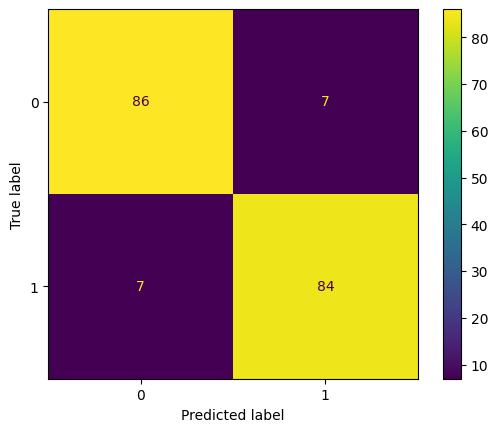

'              precision    recall  f1-score   support\n\n           0      0.925     0.925     0.925        93\n           1      0.923     0.923     0.923        91\n\n    accuracy                          0.924       184\n   macro avg      0.924     0.924     0.924       184\nweighted avg      0.924     0.924     0.924       184\n'

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = np.argmax(predict_train.predictions, axis=1)
y_test=predict_train.label_ids
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

classification_report(y_test, y_pred,
                      #output_dict=True,
                      digits=3)

In [ ]:
from google.colab import drive
import os
from datetime import *
drive.mount('/content/drive')

##
cl_report=classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(cl_report).transpose().round(2)


## Save Results
drive_path = '/content/drive/MyDrive/Output/Tables/'
#df_report.to_excel(os.path.join(drive_path, f'results_scibert_full_abstracts_{date.today()}.xlsx'))

## Save Model
#trainer.save_model('/content/drive/MyDrive/Output/Models/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Upload file runs/Jul13_19-39-39_ea47371ea3f4/events.out.tfevents.1689280502.ea47371ea3f4.1119.0: 100%|########…

To https://huggingface.co/ClinicalMetaScience/my_awesome_model
   05a6e43..c4e7573  main -> main

   05a6e43..c4e7573  main -> main

To https://huggingface.co/ClinicalMetaScience/my_awesome_model
   c4e7573..280d2fc  main -> main

   c4e7573..280d2fc  main -> main



In [ ]:
classification_report(y_test, y_pred,
                      #output_dict=True,
                      digits=3)

'              precision    recall  f1-score   support\n\n           0      0.925     0.925     0.925        93\n           1      0.923     0.923     0.923        91\n\n    accuracy                          0.924       184\n   macro avg      0.924     0.924     0.924       184\nweighted avg      0.924     0.924     0.924       184\n'